# Set up Spark and import libraries

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder\
    .config("spark.executor.memory", '32g') \
    .config('spark.executor.cores', '2') \
    .config('spark.cores.max', '8') \
    .config("spark.driver.memory",'32g') \
    .config("spark.sql.broadcastTimeout", "1000") \
    .getOrCreate()

sc = spark.sparkContext

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler
import pandas as pd
from PIL import Image
import numpy as np
import io
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
import os
import pyspark.sql.functions as F
from pyspark.mllib.linalg import Vectors


%matplotlib inline

In [3]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType
import re

In [4]:
data_dir = "/project/ds5559/BioNerds/ham"
os.chdir('/project/ds5559/BioNerds/ham')

In [5]:
!ls

HAM10000_images_part_1	archive.zip	      hmnist_8_8_L.csv
HAM10000_images_part_2	hmnist_28_28_L.csv    hmnist_8_8_RGB.csv
HAM10000_metadata.csv	hmnist_28_28_RGB.csv


# Spark read images 

In [6]:
images1 = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load("/project/ds5559/BioNerds/ham/HAM10000_images_part_1")

In [7]:
images2 = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load("/project/ds5559/BioNerds/ham/HAM10000_images_part_2")

In [8]:
images1.show(2)

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|file:/project/ds5...|2019-10-06 20:55:50|459172|[FF D8 FF DB 00 4...|
|file:/project/ds5...|2019-10-06 20:56:18|447988|[FF D8 FF DB 00 4...|
+--------------------+-------------------+------+--------------------+
only showing top 2 rows



# load ResNet50 to transfer Images

In [9]:
model = ResNet50(include_top=False)

In [10]:
bc_model_weights = sc.broadcast(model.get_weights())

def model_fn():
    """
    Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
    """
    model = ResNet50(weights=None, include_top=False)
    model.set_weights(bc_model_weights.value)
    return model


In [11]:
def preprocess(content):
    """
      Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)


In [12]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
  '''
  This method is a Scalar Iterator pandas UDF wrapping our featurization function.
  The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
  :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
  '''
  # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
  # for multiple data batches.  This amortizes the overhead of loading big models.
  model = model_fn()
  for content_series in content_series_iter:
    yield featurize_series(model, content_series)

/usr/local/spark/python/pyspark/sql/pandas/functions.py:386: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


# Transfer Image to Vectors through ResNet50

In [13]:
# Pandas UDFs on large records (e.g., very large images) can run into Out Of Memory (OOM) errors.
# If you hit such errors in the cell below, try reducing the Arrow batch size via `maxRecordsPerBatch`.
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")
# We can now run featurization on our entire Spark DataFrame.
# NOTE: This can take a long time (about 10 minutes) since it applies a large model to the full dataset.
features_df1 = images1.repartition(16).select(col("path"), featurize_udf("content").alias("features"))
#features_df.write.mode("overwrite").parquet("dbfs:/ml/tmp/flower_photos_features")
features_df2 = images2.repartition(16).select(col("path"), featurize_udf("content").alias("features"))

In [14]:
print("number of pictures in folder 1: {}".format(features_df1.count()))
print("number of pictures in folder 2: {}".format(features_df2.count()))

number of pictures in folder 1: 5000
number of pictures in folder 2: 5015


In [15]:
print(features_df1.columns)
print(features_df2.columns)

['path', 'features']
['path', 'features']


In [16]:
features_df = features_df1.union(features_df2)
print("number of pictures in combined dataframe: {}".format(features_df.count()))

number of pictures in combined dataframe: 10015


In [17]:
features_df.persist()

DataFrame[path: string, features: array<float>]

# Read metadata.csv file

In [18]:
meta_df = spark.read.csv('/project/ds5559/BioNerds/ham/HAM10000_metadata.csv', header = True, inferSchema = True)

In [19]:
meta_df.count()

10015

In [20]:
meta_df.cache

<bound method DataFrame.cache of DataFrame[lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string]>

In [21]:
meta_df.sample(0.1).show(5)

+-----------+------------+---+-------+----+------+---------------+
|  lesion_id|    image_id| dx|dx_type| age|   sex|   localization|
+-----------+------------+---+-------+----+------+---------------+
|HAM_0005132|ISIC_0025837|bkl|  histo|70.0|female|           back|
|HAM_0007571|ISIC_0029836|bkl|  histo|70.0|  male|          chest|
|HAM_0003847|ISIC_0028560|bkl|  histo|85.0|  male|upper extremity|
|HAM_0007010|ISIC_0031691|bkl|  histo|40.0|  male|          trunk|
|HAM_0001221|ISIC_0029301|bkl|  histo|45.0|  male|upper extremity|
+-----------+------------+---+-------+----+------+---------------+
only showing top 5 rows



# extract image names from path

In [22]:
pathToID = udf(lambda z: toClass(z), StringType())
spark.udf.register("pathToID", pathToID)
def toClass(s):
    p = re.compile("ISIC_[0-9]*")
    result = p.search(s)
    return(result.group(0))


In [23]:
new = features_df.withColumn('ID', pathToID('path'))#class_from_path(col('path')))

In [24]:
new.select('ID').show(5)

+------------+
|          ID|
+------------+
|ISIC_0026343|
|ISIC_0027333|
|ISIC_0026964|
|ISIC_0028228|
|ISIC_0029303|
+------------+
only showing top 5 rows



In [25]:
new.cache

<bound method DataFrame.cache of DataFrame[path: string, features: array<float>, ID: string]>

In [26]:
new.select('ID').count()

10015

# Join Image datatable with metatable

In [27]:
all_df = new.join(meta_df, new.ID == meta_df.image_id, 'left_outer')

In [28]:
all_df.select('ID').count()

10015

In [29]:
all_df.cache

<bound method DataFrame.cache of DataFrame[path: string, features: array<float>, ID: string, lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string]>

In [30]:
all_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- ID: string (nullable = true)
 |-- lesion_id: string (nullable = true)
 |-- image_id: string (nullable = true)
 |-- dx: string (nullable = true)
 |-- dx_type: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sex: string (nullable = true)
 |-- localization: string (nullable = true)



# Statistic summary of each feature

In [31]:
all_df.describe().show()

+-------+--------------------+------------+-----------+------------+-----+--------+------------------+-------+---------------+
|summary|                path|          ID|  lesion_id|    image_id|   dx| dx_type|               age|    sex|   localization|
+-------+--------------------+------------+-----------+------------+-----+--------+------------------+-------+---------------+
|  count|               10015|       10015|      10015|       10015|10015|   10015|              9958|  10015|          10015|
|   mean|                null|        null|       null|        null| null|    null|51.863828077927295|   null|           null|
| stddev|                null|        null|       null|        null| null|    null| 16.96861369249536|   null|           null|
|    min|file:/project/ds5...|ISIC_0024306|HAM_0000000|ISIC_0024306|akiec|confocal|               0.0| female|        abdomen|
|    max|file:/project/ds5...|ISIC_0034320|HAM_0007628|ISIC_0034320| vasc|   histo|              85.0|unknown|u

# Check null value of each feature

In [32]:
def NullorNoNull(df, a):
    df.filter(df[a].isNull()).show()

In [33]:
for i in all_df.columns:
    print("checking null values in column: {}".format(i))
    NullorNoNull(all_df, i)

checking null values in column: path
+----+--------+---+---------+--------+---+-------+---+---+------------+
|path|features| ID|lesion_id|image_id| dx|dx_type|age|sex|localization|
+----+--------+---+---------+--------+---+-------+---+---+------------+
+----+--------+---+---------+--------+---+-------+---+---+------------+

checking null values in column: features
+----+--------+---+---------+--------+---+-------+---+---+------------+
|path|features| ID|lesion_id|image_id| dx|dx_type|age|sex|localization|
+----+--------+---+---------+--------+---+-------+---+---+------------+
+----+--------+---+---------+--------+---+-------+---+---+------------+

checking null values in column: ID
+----+--------+---+---------+--------+---+-------+---+---+------------+
|path|features| ID|lesion_id|image_id| dx|dx_type|age|sex|localization|
+----+--------+---+---------+--------+---+-------+---+---+------------+
+----+--------+---+---------+--------+---+-------+---+---+------------+

checking null values

### Count null values in "Age"

In [34]:
all_df.filter(all_df['age'].isNull()).count()

57

### Histogram of "Age"

<AxesSubplot:ylabel='Frequency'>

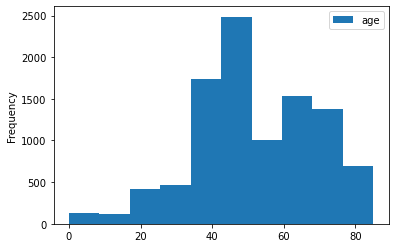

In [35]:
all_df.filter(all_df['age'].isNotNull()).select('age').toPandas().plot.hist()

In [36]:
all_df.filter(all_df['age'].isNull()).select(['age','sex']).show(57)

+----+-------+
| age|    sex|
+----+-------+
|null| female|
|null|   male|
|null| female|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|   male|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|   male|
|null|   male|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|   male|
|null|unknown|
|null|unknown|
|null|unknown|
|null| female|
|null|unknown|
|null|unknown|
|null|unknown|
|null|   male|
|null| female|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
+----+-------+



In [37]:
all_df.groupBy('sex').count().show()

+-------+-----+
|    sex|count|
+-------+-----+
|unknown|   57|
| female| 4552|
|   male| 5406|
+-------+-----+



### Histogram of "sex"

<AxesSubplot:xlabel='sex'>

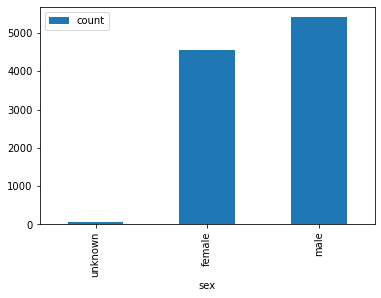

In [38]:
all_df.groupBy('sex').count().toPandas().plot.bar(x='sex', y='count')

In [39]:
all_df.filter(col("sex") == 'unknown').select('ID').show(57, truncate = False)

+------------+
|ID          |
+------------+
|ISIC_0033417|
|ISIC_0034080|
|ISIC_0033751|
|ISIC_0033190|
|ISIC_0034186|
|ISIC_0033391|
|ISIC_0032946|
|ISIC_0033064|
|ISIC_0032945|
|ISIC_0032578|
|ISIC_0032599|
|ISIC_0034019|
|ISIC_0033597|
|ISIC_0033330|
|ISIC_0033685|
|ISIC_0033631|
|ISIC_0032814|
|ISIC_0033375|
|ISIC_0033882|
|ISIC_0033841|
|ISIC_0033982|
|ISIC_0033490|
|ISIC_0033733|
|ISIC_0033065|
|ISIC_0033028|
|ISIC_0034252|
|ISIC_0032667|
|ISIC_0032740|
|ISIC_0033119|
|ISIC_0034130|
|ISIC_0033809|
|ISIC_0033332|
|ISIC_0033535|
|ISIC_0034154|
|ISIC_0032679|
|ISIC_0033864|
|ISIC_0032966|
|ISIC_0034266|
|ISIC_0033628|
|ISIC_0034045|
|ISIC_0033374|
|ISIC_0034195|
|ISIC_0033735|
|ISIC_0032529|
|ISIC_0032738|
|ISIC_0032852|
|ISIC_0033877|
|ISIC_0033782|
|ISIC_0033829|
|ISIC_0032789|
|ISIC_0033750|
|ISIC_0033472|
|ISIC_0034283|
|ISIC_0033153|
|ISIC_0033515|
|ISIC_0033353|
|ISIC_0033187|
+------------+



In [40]:
all_df.filter("ID is null").show()

+----+--------+---+---------+--------+---+-------+---+---+------------+
|path|features| ID|lesion_id|image_id| dx|dx_type|age|sex|localization|
+----+--------+---+---------+--------+---+-------+---+---+------------+
+----+--------+---+---------+--------+---+-------+---+---+------------+



In [41]:

all_df.groupBy('localization').count().show()

+---------------+-----+
|   localization|count|
+---------------+-----+
|        abdomen| 1022|
|          chest|  407|
|           hand|   90|
|           back| 2192|
|           face|  745|
|        unknown|  234|
|        genital|   48|
|          trunk| 1404|
|           foot|  319|
|            ear|   56|
|           neck|  168|
|upper extremity| 1118|
|          scalp|  128|
|          acral|    7|
|lower extremity| 2077|
+---------------+-----+



### histogram of "localization"

<AxesSubplot:xlabel='localization'>

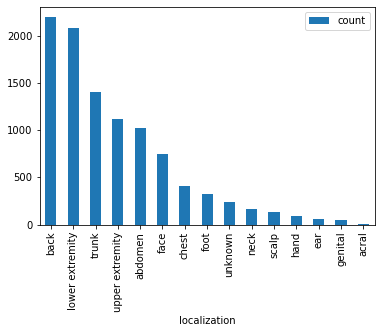

In [42]:
all_df.groupBy('localization').count().sort("count", ascending=False).toPandas().plot.bar(x='localization', y='count')

In [43]:
all_df.groupBy('dx').count().sort("count", ascending=False).show()

+-----+-----+
|   dx|count|
+-----+-----+
|   nv| 6705|
|  mel| 1113|
|  bkl| 1099|
|  bcc|  514|
|akiec|  327|
| vasc|  142|
|   df|  115|
+-----+-----+



### histogram of "cancer"

<AxesSubplot:xlabel='dx'>

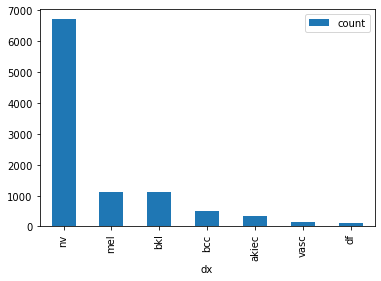

In [44]:
all_df.groupBy('dx').count().sort("count", ascending=False).toPandas().plot.bar(x='dx', y='count')

In [45]:
all_df.groupBy('dx_type').count().sort("count", ascending=False).show()

+---------+-----+
|  dx_type|count|
+---------+-----+
|    histo| 5340|
|follow_up| 3704|
|consensus|  902|
| confocal|   69|
+---------+-----+



### histogram of "cancer type"

<AxesSubplot:xlabel='dx_type'>

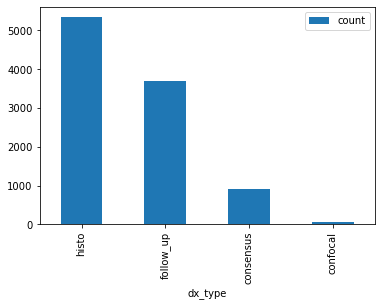

In [46]:
all_df.groupBy('dx_type').count().sort("count", ascending=False).toPandas().plot.bar(x='dx_type', y='count')

# Remove rows containing null and unknown

In [47]:

clean_df = all_df.filter((col("sex") != 'unknown') & (col("age").isNotNull()))

In [48]:
all_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- ID: string (nullable = true)
 |-- lesion_id: string (nullable = true)
 |-- image_id: string (nullable = true)
 |-- dx: string (nullable = true)
 |-- dx_type: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sex: string (nullable = true)
 |-- localization: string (nullable = true)



In [49]:
clean_df.count()

9948

In [50]:
clean_df.cache

<bound method DataFrame.cache of DataFrame[path: string, features: array<float>, ID: string, lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string]>

<AxesSubplot:ylabel='Frequency'>

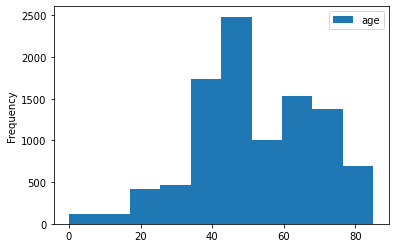

In [51]:
clean_df.select("age").sort('age', ascending = True).toPandas().plot.hist()

In [52]:
clean_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- ID: string (nullable = true)
 |-- lesion_id: string (nullable = true)
 |-- image_id: string (nullable = true)
 |-- dx: string (nullable = true)
 |-- dx_type: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sex: string (nullable = true)
 |-- localization: string (nullable = true)



In [53]:
clean_df.select('features').show(5, truncate = True)

+--------------------+
|            features|
+--------------------+
|[0.0, 0.0, 0.0, 0...|
|[4.762249, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
+--------------------+
only showing top 5 rows



## convert image feature lists to vectors

In [54]:
from pyspark.ml.linalg import Vectors, VectorUDT
to_vector = udf(lambda a: Vectors.dense(a), VectorUDT())

clean_df = clean_df.select("*", to_vector("features").alias("features_2"))

# prepare dataset. index string 

In [55]:
from pyspark.ml.feature import OneHotEncoder

label_index = StringIndexer(inputCol = 'dx', outputCol = 'indexed_dx').fit(clean_df)
label_sex = StringIndexer(inputCol = 'sex', outputCol = 'indexed_sex').fit(clean_df)
type_index = StringIndexer(inputCol = 'dx_type', outputCol = 'indexed_type').fit(clean_df)
loc_index = StringIndexer(inputCol = 'localization', outputCol = 'indexed_loc').fit(clean_df)

pipe = Pipeline(stages = [label_index, label_sex, loc_index, type_index])

In [56]:
%%time
model_pipe = pipe.fit(clean_df)

CPU times: user 973 µs, sys: 0 ns, total: 973 µs
Wall time: 2.66 ms


In [57]:
%%time
transformed_table = model_pipe.transform(clean_df)
transformed_table.show(5)

+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+------------+--------------------+----------+-----------+-----------+------------+
|                path|            features|          ID|  lesion_id|    image_id| dx|  dx_type| age|   sex|localization|          features_2|indexed_dx|indexed_sex|indexed_loc|indexed_type|
+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+------------+--------------------+----------+-----------+-----------+------------+
|file:/project/ds5...|[0.0, 0.0, 0.0, 0...|ISIC_0026343|HAM_0002346|ISIC_0026343|bcc|    histo|70.0|  male|        face|[0.0,0.0,0.0,0.0,...|       3.0|        0.0|        5.0|         0.0|
|file:/project/ds5...|[4.762249, 0.0, 0...|ISIC_0027333|HAM_0000564|ISIC_0027333| nv|follow_up|40.0|  male|        foot|[4.76224899291992...|       0.0|        0.0|        7.0|         1.0|
|file:/project/ds5...|[0.0, 0.0, 0.0, 0...|ISIC_00

In [58]:
transformed_table.select("dx", "indexed_dx").groupby("dx","indexed_dx").count().show()

+-----+----------+-----+
|   dx|indexed_dx|count|
+-----+----------+-----+
|  bcc|       3.0|  514|
|  mel|       1.0| 1111|
|   nv|       0.0| 6650|
|  bkl|       2.0| 1089|
|   df|       6.0|  115|
| vasc|       5.0|  142|
|akiec|       4.0|  327|
+-----+----------+-----+



# correlation and heatmap

In [61]:
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
corr = VectorAssembler(inputCols=['indexed_dx','indexed_sex','indexed_loc', 'indexed_type','age'], outputCol="corr_features")
corr_vector = corr.transform(transformed_table).select("corr_features")
matrix = Correlation.corr(corr_vector, "corr_features").collect()[0][0]

In [63]:
corrmatrix = matrix.toArray().tolist()
corrmatrix

[[1.0,
  -0.06191662286970777,
  0.08122878869996165,
  -0.1526610567099114,
  0.3571806487929663],
 [-0.06191662286970777,
  1.0,
  0.014667160713789575,
  0.05392398906110483,
  -0.17138734850698364],
 [0.08122878869996165,
  0.014667160713789575,
  1.0,
  0.00962727094461431,
  0.015010169580166714],
 [-0.1526610567099114,
  0.05392398906110483,
  0.00962727094461431,
  1.0,
  -0.14198218138408514],
 [0.3571806487929663,
  -0.17138734850698364,
  0.015010169580166714,
  -0.14198218138408514,
  1.0]]

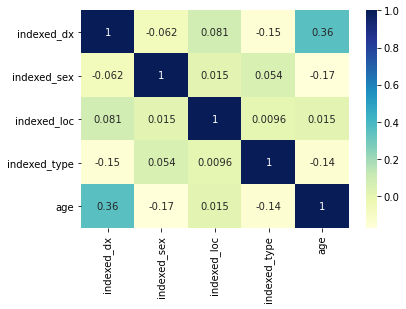

In [116]:
ax = sns.heatmap(corrmatrix, cmap="YlGnBu", annot=True, 
                 xticklabels =['indexed_dx','indexed_sex','indexed_loc', 'indexed_type', 'age'], 
                 yticklabels =['indexed_dx','indexed_sex','indexed_loc', 'indexed_type', 'age'])

# Save file

In [ ]:
transformed_table.write.save("/project/ds5559/BioNerds/saved_data/clean_indexed.parquet")